In [2]:
import torch, torch.nn as nn
import numpy as np, matplotlib.pyplot as plt
from tqdm.auto import tqdm

def seq_mlp(init, mlp, fin, act):
    modules = [nn.Linear(init, mlp[0]), act]
    for i in range(len(mlp) - 1):
        modules.append(nn.Linear(mlp[i], mlp[i+1]))
        modules.append(act)

    modules.append(nn.Linear(mlp[-1], fin)) #self.spl for spline

    return modules

def nan_hook(self, inp, output):
    if not isinstance(output, tuple):
        outputs = [output]
    else:
        outputs = output

    for i, out in enumerate(outputs):
        nan_mask = torch.isnan(out)
        if nan_mask.any():
            print(outputs)
            print("In ", self.__class__.__name__)
            raise RuntimeError(f"Found NAN in output {i}")

c:\Users\Hanse Kim\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class EvalEig(nn.Module):
    def __init__(self, eval_para):
        super().__init__()
        self.rn = eval_para['r_dsc']*eval_para['para_1'] # maintain Delta r
        self.rm = eval_para['r_infty']*eval_para['para_1'] # maintain V(infty) ~ 0
        self.ln = eval_para['l_max']+1
        self.para = eval_para

        # l x r
        self.r_dsc = torch.linspace(self.rm/self.rn, self.rm, self.rn)
        self.l_dsc = torch.arange(0,self.ln, dtype = torch.int).view(1,-1,1,1)
        
        self.r_dsc_pw = (torch.linspace(1/self.rn, 1, self.rn).view(-1,1).expand(-1,eval_para['pw']+1)**(torch.cat((torch.tensor([-1]), torch.arange(1, eval_para['pw']+1))))).T
    
    def dsc_eigs(self, ptl):
        dsc_lap = (-2*torch.eye(self.rn) + torch.diag(torch.ones(self.rn-1),1) + torch.diag(torch.ones(self.rn-1),-1))*(self.rn/self.rm)**2
        dsc_lap = dsc_lap.view(1, 1, self.rn, self.rn)
        dsc_ptl = torch.diag_embed(ptl).view(ptl.shape[0],1,self.rn,self.rn)
        dsc_eff = self.l_dsc*(self.l_dsc+1)*torch.diag(1/self.r_dsc**2).view(1, 1, self.rn,self.rn)
        
        dsc_hmt = (-self.para['para_0']*dsc_lap + dsc_ptl + self.para['para_0']*dsc_eff)

        #print(dsc_hmt)

        evl, _ = torch.linalg.eigh(dsc_hmt)
        # bound state condition
        # evl[evl>0] = torch.tensor(0)

        return evl

class InvEig(EvalEig):
    def __init__(self, clip_size, eval_para, model_para):
        super().__init__(eval_para)
        # model
        modules = seq_mlp(init = clip_size*self.ln, mlp = model_para['mlp'],
                          fin = eval_para['pw'] + 1, act = nn.ReLU())
        self.mlp = nn.Sequential(*modules)


    def forward(self, energy):
        # obtain potential via model
        # via mlp
        coeffs_temp = self.mlp(energy.reshape(energy.shape[0]*energy.shape[1],energy.shape[2]))
        self.coeffs = torch.cat((-torch.abs(coeffs_temp[:,:1]),coeffs_temp[:,1:]),dim=1)
        ptl_md = self.coeffs @ self.r_dsc_pw

        # calculate learned energy
        evl_md = self.dsc_eigs(ptl_md)

        return ptl_md, evl_md

In [40]:
eval_para = {
        # evaluation model
        'r_infty' : 50, # high r_infty maintains V(infty) ~ 0
        'r_dsc' : 1000, # computation time vs accuracy; maintain delta r ~ 0
        'l_max' : 0, # maximum l_max to evaluate radial schrodinger upto
        
        # potential specifics
        'ptl_form' : 'coulomb',
        'para_0' : 1, # hbar^2/2m
        'para_1' : 1, # scales energy; scales horizontally (r_rat) and modelwise (r_dsc)

        # model specifics
        'precision' : 64, # 32 or 64 bit
        'pw' : 20, # consider 1/r and up to r^n
        'batch_dim' : 400,
        }

model_para = {
        # model
        'mlp' : [100, 100, 100],

        # training
        'epoch' : 100,
        'lr' : 1e-2,

        # loss regularisation
        'reg1' : 1e-1, # smoothness
        
        }

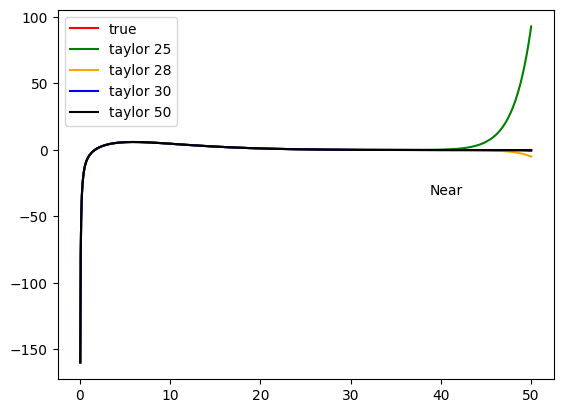

In [54]:
eval = EvalEig(eval_para)
clip_size = 30
# robustness test
ptl_tr_near = -8/eval.r_dsc + 20*torch.exp(-eval.r_dsc/5)*eval.r_dsc/5
#ptl_tr_near = -8/eval.r_dsc

def taylor(n):
    ptl = -8/eval.r_dsc 
    term = 20*eval.r_dsc/5
    for i in range(n):
        ptl += term
        term = term * (-eval.r_dsc/5)/(i+1)
    return ptl

evl_tr_near = eval.dsc_eigs(ptl_tr_near.reshape(1,1,eval.rn))

plt.plot(eval.r_dsc, ptl_tr_near, label='true', color = 'red')
plt.plot(eval.r_dsc, taylor(25), label='taylor 25', color = 'green')
plt.plot(eval.r_dsc, taylor(28), label='taylor 28', color = 'orange')
plt.plot(eval.r_dsc, taylor(30), label='taylor 30', color = 'blue')
plt.plot(eval.r_dsc, taylor(50), label='taylor 50', color = 'black')
#plt.plot(eval.r_dsc, ptl_init[i].squeeze(0).detach(), label='model_i', color = 'green')
plt.annotate(f"Near", xy = (0.75, 0.5), xycoords="axes fraction")
plt.legend()